<a href="https://colab.research.google.com/github/A00785001/TC5035/blob/main/pbstream_Data_Extractor_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 Cartographer PBSTREAM Data Extractor
## Comprehensive SLAM Data Analysis Pipeline - 5 Sections

In [1]:
import struct
import zlib
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.protobuf.internal.decoder import _DecodeVarint32, _DecodeVarint
from google.colab import drive
from ipywidgets import interact, FloatSlider
import csv

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
SESSION_ID = "session_20251022_155137"
BASE_PATH = f"/content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/{SESSION_ID}"
PBSTREAM_FILE = f"{BASE_PATH}/map.pbstream"

In [3]:
def extract_xy(field5_data):
    pos = 0
    x = y = None
    while pos < len(field5_data):
        try:
            tag, pos = _DecodeVarint32(field5_data, pos)
            fn = tag >> 3
            wt = tag & 0x7
            if fn == 7 and wt == 2:
                length, pos = _DecodeVarint32(field5_data, pos)
                f7_data = field5_data[pos:pos + length]
                f7_pos = 0
                while f7_pos < len(f7_data):
                    try:
                        f7_tag, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                        f7_fn = f7_tag >> 3
                        f7_wt = f7_tag & 0x7
                        if f7_fn == 1 and f7_wt == 2:
                            tl, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            td = f7_data[f7_pos:f7_pos + tl]
                            tp = 0
                            while tp < len(td):
                                try:
                                    tt, tp = _DecodeVarint32(td, tp)
                                    tf = tt >> 3
                                    tw = tt & 0x7
                                    if tw == 1 and tp + 8 <= len(td):
                                        val = struct.unpack('<d', td[tp:tp+8])[0]
                                        if tf == 1:
                                            x = val
                                        elif tf == 2:
                                            y = val
                                        tp += 8
                                    else:
                                        break
                                except:
                                    break
                            f7_pos += tl
                            break
                        elif f7_wt == 2:
                            l2, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            f7_pos += l2
                        else:
                            break
                    except:
                        break
                pos += length
                break
            elif wt == 0:
                _, pos = _DecodeVarint32(field5_data, pos)
            elif wt == 1:
                pos += 8
            elif wt == 2:
                l, pos = _DecodeVarint32(field5_data, pos)
                pos += l
            elif wt == 5:
                pos += 4
            else:
                break
        except:
            break
    return x, y


def extract_timestamp(node_data):
    """Extract timestamp from Field 1 (node ID message)"""
    pos = 0
    while pos < len(node_data):
        try:
            tag, pos = _DecodeVarint32(node_data, pos)
            fn = tag >> 3
            wt = tag & 0x7

            # Timestamp is inside Field 5 (pose), not Field 1!
            if fn == 5 and wt == 2:
                length, pos = _DecodeVarint32(node_data, pos)
                field1_data = node_data[pos:pos + length]
                f1_pos = 0
                while f1_pos < len(field1_data):
                    try:
                        f1_tag, f1_pos = _DecodeVarint32(field1_data, f1_pos)
                        f1_fn = f1_tag >> 3
                        f1_wt = f1_tag & 0x7
                        if f1_fn == 1 and f1_wt == 0:  # Timestamp
                            timestamp, f1_pos = _DecodeVarint(field1_data, f1_pos)
                            return timestamp
                        elif f1_wt == 0:
                            _, f1_pos = _DecodeVarint32(field1_data, f1_pos)
                        elif f1_wt == 1:
                            f1_pos += 8
                        elif f1_wt == 2:
                            l, f1_pos = _DecodeVarint32(field1_data, f1_pos)
                            f1_pos += l
                        elif f1_wt == 5:
                            f1_pos += 4
                        else:
                            break
                    except:
                        break
                return None
            elif wt == 0:
                _, pos = _DecodeVarint32(node_data, pos)
            elif wt == 1:
                pos += 8
            elif wt == 2:
                l, pos = _DecodeVarint32(node_data, pos)
                pos += l
            elif wt == 5:
                pos += 4
            else:
                break
        except:
            break
    return None


## 🔧 Helper Functions (ORIGINAL - DO NOT MODIFY)

---

# 📚 Cartographer PBSTREAM Format Documentation

## 🏗️ File Structure

```
PBSTREAM FILE
├─ [8-byte header]
└─ [Messages]* (repeated)
   ├─ 8 bytes: message length (uint64, little-endian)
   └─ N bytes: gzip-compressed protobuf message
```

---

## 📋 Message Types

### 1. POSE_GRAPH (Field 1)
Complete optimized graph structure containing all trajectories, nodes, submaps, and loop closure constraints after SLAM optimization.

**Typical Count:** 1-2 messages (usually at end of file)

### 2. ALL_TRAJECTORY_BUILDER_OPTIONS (Field 2)
SLAM algorithm configuration parameters and tuning settings.

**Typical Count:** 1 message (at start of file)

### 3. SUBMAP (Field 3)
2D/3D probability grids representing mapped areas. Each submap is a tile of the complete map.

### 4. NODE (Field 4) ⭐ PRIMARY DATA
Trajectory nodes containing robot pose, timestamp, and sensor data at each mapping step.

### 5. TRAJECTORY_DATA (Field 5)
Metadata about trajectories (IDs, relationships between multiple trajectories).

### 6. IMU_DATA (Field 6)
IMU sensor readings (accelerometer, gyroscope) if IMU was used during mapping.

---

## 🎯 NODE Structure (Field 4) - DETAILED

This is the **primary data structure** containing pose and sensor information.

```
NODE (Field 4)
├─ Field 1: Node metadata (usually empty, 0-2 bytes)
└─ Field 5: POSE DATA
   ├─ Field 1: TIMESTAMP (int64 varint)
   │   └─ Format: 100-nanosecond ticks since Windows epoch (1601-01-01)
   │   └─ Conversion: (timestamp - 621355968000000000) / 10000000 = Unix seconds
   │
   ├─ Field 2: Metadata (9-18 bytes, varies by node)
   ├─ Field 3: POINT CLOUD DATA (600-950 bytes, raw LIDAR scan)
   ├─ Field 4: (empty)
   ├─ Field 5: (empty)
   │
   └─ Field 7: POSE (TRANSFORM)
      ├─ Field 1: TRANSLATION
      │  ├─ Field 1: x (double) - meters
      │  ├─ Field 2: y (double) - meters
      │  └─ Field 3: z (double) - meters
      │
      └─ Field 2: ROTATION (quaternion)
         ├─ Field 1: x (double)
         ├─ Field 2: y (double)
         ├─ Field 3: z (double)
         └─ Field 4: w (double) - normalized
```

---

## 🔧 Protobuf Wire Types

| Wire Type | Name | Description |
|-----------|------|-------------|
| 0 | VARINT | Variable-length integer (int32, int64, uint32, uint64, bool, enum) |
| 1 | 64BIT | Fixed 8 bytes (double, fixed64, sfixed64) |
| 2 | LENGTH_DELIM | Length-prefixed (string, bytes, nested messages, packed repeated) |
| 5 | 32BIT | Fixed 4 bytes (float, fixed32, sfixed32) |

---

## 📚 Important Notes

- **Timestamp Format:** Cartographer uses "Universal Time" (100-nanosecond ticks since Windows epoch)
- **Coordinate System:** Right-handed with Z-up (typical for 2D: z=0)
- **Quaternions:** Stored as (x, y, z, w) and are normalized (magnitude = 1.0)
- **Compression:** All messages are gzip-compressed with window bits = 16 + MAX_WBITS
- **Endianness:** Little-endian for all multi-byte values
- **Field Numbers:** In protobuf, field numbers 1-15 use 1 byte, 16+ use 2+ bytes

---

---
# 1️⃣ FILE VALIDATION
---

In [4]:
print("🔍 VALIDATING PBSTREAM FILE...\n")

with open(PBSTREAM_FILE, 'rb') as f:
    data = f.read()

print(f"File size: {len(data):,} bytes ({len(data)/1024/1024:.2f} MB)")
print(f"Header: {' '.join(f'{b:02x}' for b in data[:8])}")
print()

# Count message types
pos = 8
msg_types = {}
first_node = None

while pos < len(data):
    try:
        if pos + 8 > len(data): break
        msg_len = struct.unpack('<Q', data[pos:pos+8])[0]
        pos += 8
        if msg_len == 0 or pos + msg_len > len(data): break
        compressed = data[pos:pos + msg_len]
        pos += msg_len
        try:
            msg_data = zlib.decompress(compressed, 16 + zlib.MAX_WBITS)
        except: continue
        if len(msg_data) < 2: continue
        tag, _ = _DecodeVarint32(msg_data, 0)
        field_num = tag >> 3
        msg_types[field_num] = msg_types.get(field_num, 0) + 1

        # Capture first node for timestamp example
        if field_num == 4 and first_node is None:
            node_pos = 0
            tag, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_len, node_pos = _DecodeVarint32(msg_data, node_pos)
            first_node = msg_data[node_pos:node_pos + node_len]
    except: break

msg_names = {1: 'POSE_GRAPH', 2: 'BUILDER_OPTIONS', 3: 'SUBMAP', 4: 'NODE'}
print("✅ Message counts:")
for fn in sorted(msg_types.keys()):
    name = msg_names.get(fn, f'UNKNOWN_{fn}')
    print(f"   {name:20} (Field {fn}): {msg_types[fn]:,}")

# Show timestamp conversion example from first node
if first_node:
    timestamp = extract_timestamp(first_node)
    if timestamp:
        print(f"\n✅ Timestamp example (first node):")
        print(f"   Raw ticks (Year 1 epoch): {timestamp}")
        # Convert: ticks × 100 → ns since Year 1, then subtract offset to Unix epoch
        ns_since_year1 = timestamp * 100
        unix_ns = ns_since_year1 - 62135596800000000000
        timestamp_secs = unix_ns // 1_000_000_000
        timestamp_nsecs = unix_ns % 1_000_000_000
        print(f"   Unix timestamp: {timestamp_secs} seconds")
        print(f"   Nanoseconds in second: {timestamp_nsecs} ns")

        import datetime
        dt = datetime.datetime.fromtimestamp(timestamp_secs)
        print(f"   Date/time: {dt.strftime('%Y-%m-%d %H:%M:%S')}.{timestamp_nsecs//1000000:03d}")

print(f"\n✅ File structure: Valid")

🔍 VALIDATING PBSTREAM FILE...

File size: 2,800,733 bytes (2.67 MB)
Header: db 01 f5 5b 7b 1f 1d 7b

✅ Message counts:
   POSE_GRAPH           (Field 1): 2
   BUILDER_OPTIONS      (Field 2): 1
   SUBMAP               (Field 3): 36
   NODE                 (Field 4): 1,256

✅ Timestamp example (first node):
   Raw ticks (Year 1 epoch): 638967723732811315
   Unix timestamp: 1761175573 seconds
   Nanoseconds in second: 281131500 ns
   Date/time: 2025-10-22 23:26:13.281

✅ File structure: Valid


In [5]:
def extract_full_pose(field5_data):
    """Extract full pose: x, y, z, quat_x, quat_y, quat_z, quat_w, timestamp"""
    pos = 0
    x = y = z = qx = qy = qz = qw = timestamp = None

    while pos < len(field5_data):
        try:
            tag, pos = _DecodeVarint32(field5_data, pos)
            fn = tag >> 3
            wt = tag & 0x7

            if fn == 1 and wt == 0:  # Timestamp
                timestamp, pos = _DecodeVarint(field5_data, pos)

            elif fn == 7 and wt == 2:  # Pose
                length, pos = _DecodeVarint32(field5_data, pos)
                f7_data = field5_data[pos:pos + length]
                f7_pos = 0

                while f7_pos < len(f7_data):
                    try:
                        f7_tag, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                        f7_fn = f7_tag >> 3
                        f7_wt = f7_tag & 0x7

                        if f7_fn == 1 and f7_wt == 2:  # Translation
                            tl, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            td = f7_data[f7_pos:f7_pos + tl]
                            tp = 0
                            while tp < len(td):
                                try:
                                    tt, tp = _DecodeVarint32(td, tp)
                                    tf = tt >> 3
                                    tw = tt & 0x7
                                    if tw == 1 and tp + 8 <= len(td):
                                        val = struct.unpack('<d', td[tp:tp+8])[0]
                                        if tf == 1: x = val
                                        elif tf == 2: y = val
                                        elif tf == 3: z = val
                                        tp += 8
                                    else:
                                        break
                                except:
                                    break
                            f7_pos += tl

                        elif f7_fn == 2 and f7_wt == 2:  # Rotation
                            rl, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            rd = f7_data[f7_pos:f7_pos + rl]
                            rp = 0
                            while rp < len(rd):
                                try:
                                    rt, rp = _DecodeVarint32(rd, rp)
                                    rf = rt >> 3
                                    rw = rt & 0x7
                                    if rw == 1 and rp + 8 <= len(rd):
                                        val = struct.unpack('<d', rd[rp:rp+8])[0]
                                        if rf == 1: qx = val
                                        elif rf == 2: qy = val
                                        elif rf == 3: qz = val
                                        elif rf == 4: qw = val
                                        rp += 8
                                    else:
                                        break
                                except:
                                    break
                            f7_pos += rl

                        elif f7_wt == 2:
                            l, f7_pos = _DecodeVarint32(f7_data, f7_pos)
                            f7_pos += l
                        else:
                            break
                    except:
                        break
                pos += length

            elif wt == 0:
                _, pos = _DecodeVarint32(field5_data, pos)
            elif wt == 1:
                pos += 8
            elif wt == 2:
                l, pos = _DecodeVarint32(field5_data, pos)
                pos += l
            elif wt == 5:
                pos += 4
            else:
                break
        except:
            break

    return x, y, z, qx, qy, qz, qw, timestamp

---
# 2️⃣ TRAJECTORY EXTRACTION AND ANALYSIS
---

In [6]:
print("🛤️ EXTRACTING TRAJECTORY DATA...\n")

with open(PBSTREAM_FILE, 'rb') as f:
    data = f.read()

pos = 8
trajectory_data = []
node_idx = 0

while pos < len(data):
    try:
        if pos + 8 > len(data): break
        msg_len = struct.unpack('<Q', data[pos:pos+8])[0]
        pos += 8
        if msg_len == 0 or pos + msg_len > len(data): break
        compressed = data[pos:pos + msg_len]
        pos += msg_len

        try:
            msg_data = zlib.decompress(compressed, 16 + zlib.MAX_WBITS)
        except:
            continue

        if len(msg_data) < 2: continue
        tag, _ = _DecodeVarint32(msg_data, 0)
        field_num = tag >> 3

        if field_num == 4:  # NODE
            node_pos = 0
            tag, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_len, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_data = msg_data[node_pos:node_pos + node_len]

            # Find Field 5
            inner_pos = 0
            while inner_pos < len(node_data):
                tag, inner_pos = _DecodeVarint32(node_data, inner_pos)
                fn = tag >> 3
                wt = tag & 0x7
                if fn == 5 and wt == 2:
                    f5_len, inner_pos = _DecodeVarint32(node_data, inner_pos)
                    f5_data = node_data[inner_pos:inner_pos + f5_len]

                    x, y, z, qx, qy, qz, qw, timestamp = extract_full_pose(f5_data)

                    if x is not None and y is not None:
                        if timestamp:
                            # Convert: ticks × 100 → ns since Year 1, subtract offset for Unix epoch
                            ns_since_year1 = timestamp * 100
                            unix_ns = ns_since_year1 - 62135596800000000000
                            timestamp_secs = int(unix_ns // 1_000_000_000)
                            timestamp_nsecs = int(unix_ns % 1_000_000_000)
                        else:
                            timestamp_secs = None
                            timestamp_nsecs = None

                        trajectory_data.append({
                            'node_id': node_idx,
                            'timestamp_secs': timestamp_secs,
                            'timestamp_nsecs': timestamp_nsecs,
                            'x_m': x,
                            'y_m': y,
                            'z_m': z if z is not None else 0.0,
                            'quat_x': qx if qx is not None else 0.0,
                            'quat_y': qy if qy is not None else 0.0,
                            'quat_z': qz if qz is not None else 0.0,
                            'quat_w': qw if qw is not None else 1.0
                        })
                        node_idx += 1
                    break
                elif wt == 0:
                    _, inner_pos = _DecodeVarint32(node_data, inner_pos)
                elif wt == 1:
                    inner_pos += 8
                elif wt == 2:
                    l, inner_pos = _DecodeVarint32(node_data, inner_pos)
                    inner_pos += l
                elif wt == 5:
                    inner_pos += 4
    except:
        break

df_trajectory = pd.DataFrame(trajectory_data)

# Ensure timestamp columns are integers
if len(df_trajectory) > 0:
    df_trajectory['timestamp_secs'] = df_trajectory['timestamp_secs'].fillna(0).astype(int)
    df_trajectory['timestamp_nsecs'] = df_trajectory['timestamp_nsecs'].fillna(0).astype(int)


print(f"✅ Extracted: {len(df_trajectory)} nodes")
print(f"\n📝 Timestamp format:")
print(f"   timestamp_secs: Unix timestamp (seconds since 1970-01-01)")
print(f"   timestamp_nsecs: Nanoseconds within that second (0-999,999,999)")
print(f"\n📋 First 5 rows:")
display(df_trajectory.head())
print(f"\n📋 Last 5 rows:")
display(df_trajectory.tail())

🛤️ EXTRACTING TRAJECTORY DATA...

✅ Extracted: 1255 nodes

📝 Timestamp format:
   timestamp_secs: Unix timestamp (seconds since 1970-01-01)
   timestamp_nsecs: Nanoseconds within that second (0-999,999,999)

📋 First 5 rows:


,node_id,timestamp_secs,timestamp_nsecs,x_m,y_m,z_m,quat_x,quat_y,quat_z,quat_w
0,0,1761175578,341865800,-0.001466,0.004393,0.0,0.0,0.0,0.001625,0.999999
1,1,1761175578,476540500,-0.003856,0.002816,0.0,0.0,0.0,0.017387,0.999849
2,2,1761175578,611894500,0.001183,0.002219,0.0,0.0,0.0,0.030296,0.999541
3,3,1761175578,867448600,0.041088,0.004711,0.0,0.0,0.0,0.006010,0.999982
4,4,1761175579,2461300,0.076415,0.010777,0.0,0.0,0.0,-0.005306,0.999986



📋 Last 5 rows:


,node_id,timestamp_secs,timestamp_nsecs,x_m,y_m,z_m,quat_x,quat_y,quat_z,quat_w
1250,1250,1761175962,839079300,2.844030,6.390513,0.0,0.0,0.0,0.876729,-0.480985
1251,1251,1761175963,632571600,2.768131,6.164998,0.0,0.0,0.0,0.879331,-0.476211
1252,1252,1761175963,902584000,2.712850,6.092377,0.0,0.0,0.0,0.885523,-0.464595
1253,1253,1761175964,296024600,2.607575,6.054640,0.0,0.0,0.0,0.891796,-0.452439
1254,1254,1761175964,946802100,2.464423,6.084261,0.0,0.0,0.0,0.897377,-0.441265


In [7]:
# Verify timestamp format
print("🔍 TIMESTAMP VERIFICATION\n")
sample = df_trajectory.iloc[0]
print(f"Sample node (first):")
print(f"   timestamp_secs: {sample['timestamp_secs']} (type: {type(sample['timestamp_secs']).__name__})")
print(f"   timestamp_nsecs: {sample['timestamp_nsecs']} (type: {type(sample['timestamp_nsecs']).__name__})")

if sample['timestamp_secs'] is not None:
    import datetime
    dt = datetime.datetime.fromtimestamp(int(sample['timestamp_secs']))
    nsecs = int(sample['timestamp_nsecs']) if sample['timestamp_nsecs'] is not None else 0
    print(f"   Readable: {dt.strftime('%Y-%m-%d %H:%M:%S')}.{nsecs//1000000:03d}")
    print(f"\n✅ Timestamps correctly formatted as (seconds, nanoseconds)")


🔍 TIMESTAMP VERIFICATION

Sample node (first):
   timestamp_secs: 1761175578.0 (type: float64)
   timestamp_nsecs: 341865800.0 (type: float64)
   Readable: 2025-10-22 23:26:18.341

✅ Timestamps correctly formatted as (seconds, nanoseconds)


In [8]:
# Visualize trajectory (without loop closures)
print("📈 VISUALIZING TRAJECTORY...\n")

x = df_trajectory['x_m'].values
y = df_trajectory['y_m'].values

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x, y=y, mode='lines',
    line=dict(color='lightblue', width=2),
    name='Path',
    hovertemplate='Node %{pointNumber}<br>X: %{x:.3f}m<br>Y: %{y:.3f}m<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=x, y=y, mode='markers',
    marker=dict(color='lightblue', size=3, opacity=0.4),
    name='Nodes', showlegend=False
))

fig.add_trace(go.Scatter(
    x=[x[0]], y=[y[0]], mode='markers',
    marker=dict(color='green', size=20, symbol='circle', line=dict(color='black', width=2)),
    name='Start', hovertemplate='START<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=[x[-1]], y=[y[-1]], mode='markers',
    marker=dict(color='red', size=20, symbol='x', line=dict(color='black', width=2)),
    name='End', hovertemplate='END<extra></extra>'
))

fig.update_layout(
    title=f'Robot Trajectory Path<br><sub>{len(df_trajectory)} nodes recorded</sub>',
    xaxis_title='X Position (meters)', yaxis_title='Y Position (meters)', height=800,
    hovermode='closest', plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgray', dtick=0.5),
    yaxis=dict(showgrid=True, gridcolor='lightgray', scaleanchor='x', dtick=0.5),
    legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.9)')
)

fig.show()

📈 VISUALIZING TRAJECTORY...



---
# 3️⃣ LOOP CLOSURE EXTRACTION AND ANALYSIS
---

In [9]:
print("🔗 EXTRACTING LOOP CLOSURES (ORIGINAL ALGORITHM)...\n")

# EXACT ORIGINAL EXTRACTION CODE
with open(PBSTREAM_FILE, 'rb') as f:
    data = f.read()

pos = 8
trajectory = []  # (x, y, timestamp)
loop_closure_pairs = []
total_constraints = 0
submap_to_nodes = {}
loop_closure_count = 0

msg_count = 0
pg_count = 0

while pos < len(data):
    try:
        if pos + 8 > len(data): break
        msg_len = struct.unpack('<Q', data[pos:pos+8])[0]
        pos += 8
        if msg_len == 0 or msg_len > len(data) or pos + msg_len > len(data): break
        compressed = data[pos:pos + msg_len]
        pos += msg_len
        msg_count += 1

        try:
            msg_data = zlib.decompress(compressed, 16 + zlib.MAX_WBITS)
        except:
            continue

        if len(msg_data) < 2: continue
        tag, _ = _DecodeVarint32(msg_data, 0)
        field_number = tag >> 3

        if field_number == 4:  # Node
            node_pos = 0
            tag, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_len, node_pos = _DecodeVarint32(msg_data, node_pos)
            node_data = msg_data[node_pos:node_pos + node_len]
            timestamp = extract_timestamp(node_data)

            inner_pos = 0
            while inner_pos < len(node_data):
                tag, inner_pos = _DecodeVarint32(node_data, inner_pos)
                fn = tag >> 3
                wt = tag & 0x7
                if fn == 5 and wt == 2:
                    f5_len, inner_pos = _DecodeVarint32(node_data, inner_pos)
                    f5_data = node_data[inner_pos:inner_pos + f5_len]
                    x, y = extract_xy(f5_data)
                    if x is not None and y is not None:
                        trajectory.append((x, y, timestamp))
                    break
                elif wt == 0:
                    _, inner_pos = _DecodeVarint32(node_data, inner_pos)
                elif wt == 1:
                    inner_pos += 8
                elif wt == 2:
                    l, inner_pos = _DecodeVarint32(node_data, inner_pos)
                    inner_pos += l
                elif wt == 5:
                    inner_pos += 4

        elif field_number == 1:  # PoseGraph
            pg_count += 1
            if pg_count == 2:  # CRITICAL: Use second POSE_GRAPH message
                pg_pos = 0
                tag, pg_pos = _DecodeVarint32(msg_data, pg_pos)
                pg_len, pg_pos = _DecodeVarint32(msg_data, pg_pos)
                pg_data = msg_data[pg_pos:pg_pos + pg_len]

                p = 0
                while p < len(pg_data):
                    try:
                        tag, p = _DecodeVarint32(pg_data, p)
                        fn = tag >> 3
                        wt = tag & 0x7

                        if fn == 2 and wt == 2:  # CRITICAL: Field 2 = Constraint
                            total_constraints += 1
                            cl, p = _DecodeVarint32(pg_data, p)
                            cd = pg_data[p:p+cl]

                            cp = 0
                            ctag = 0
                            node_idx = None
                            submap_idx = None

                            while cp < len(cd):
                                try:
                                    ct, cp = _DecodeVarint32(cd, cp)
                                    cf = ct >> 3
                                    cw = ct & 0x7

                                    if cf == 1 and cw == 2:  # Submap ID
                                        sid_len, cp = _DecodeVarint32(cd, cp)
                                        sid_data = cd[cp:cp+sid_len]
                                        sp = 0
                                        while sp < len(sid_data):
                                            st, sp = _DecodeVarint32(sid_data, sp)
                                            sf = st >> 3
                                            sw = st & 0x7
                                            if sf == 2 and sw == 0:
                                                submap_idx, sp = _DecodeVarint32(sid_data, sp)
                                                break
                                            elif sw == 0:
                                                _, sp = _DecodeVarint32(sid_data, sp)
                                            elif sw == 2:
                                                sl, sp = _DecodeVarint32(sid_data, sp)
                                                sp += sl
                                            else:
                                                break
                                        cp += sid_len

                                    elif cf == 2 and cw == 2:  # Node ID
                                        nid_len, cp = _DecodeVarint32(cd, cp)
                                        nid_data = cd[cp:cp+nid_len]
                                        nid_pos = 0
                                        while nid_pos < len(nid_data):
                                            nt, nid_pos = _DecodeVarint32(nid_data, nid_pos)
                                            nf = nt >> 3
                                            nw = nt & 0x7
                                            if nf == 2 and nw == 0:
                                                node_idx, nid_pos = _DecodeVarint32(nid_data, nid_pos)
                                                break
                                            elif nw == 0:
                                                _, nid_pos = _DecodeVarint32(nid_data, nid_pos)
                                            elif nw == 2:
                                                nl, nid_pos = _DecodeVarint32(nid_data, nid_pos)
                                                nid_pos += nl
                                            else:
                                                break
                                        cp += nid_len

                                    elif cf == 5 and cw == 0:  # Tag field
                                        ctag, cp = _DecodeVarint32(cd, cp)

                                    elif cw == 0:
                                        _, cp = _DecodeVarint32(cd, cp)
                                    elif cw == 1:
                                        cp += 8
                                    elif cw == 2:
                                        cll, cp = _DecodeVarint32(cd, cp)
                                        cp += cll
                                    elif cw == 5:
                                        cp += 4
                                    else:
                                        break
                                except:
                                    break

                            if ctag == 0 and node_idx is not None and submap_idx is not None:
                                # INTRA_SUBMAP
                                if submap_idx not in submap_to_nodes:
                                    submap_to_nodes[submap_idx] = []
                                submap_to_nodes[submap_idx].append(node_idx)

                            elif ctag == 1 and node_idx is not None and submap_idx is not None:
                                # INTER_SUBMAP: Loop closure
                                loop_closure_count += 1
                                loop_closure_pairs.append((submap_idx, node_idx))

                            p += cl
                        elif wt == 0:
                            _, p = _DecodeVarint32(pg_data, p)
                        elif wt == 1:
                            p += 8
                        elif wt == 2:
                            ll, p = _DecodeVarint32(pg_data, p)
                            p += ll
                        elif wt == 5:
                            p += 4
                        else:
                            break
                    except:
                        break
    except:
        break

# Process loop closures
processed_loop_pairs = []
invalid_count = 0

for submap_idx, node_idx in loop_closure_pairs:
    if node_idx >= len(trajectory):
        invalid_count += 1
        continue

    if submap_idx in submap_to_nodes and len(submap_to_nodes[submap_idx]) > 0:
        nodes_in_submap = [n for n in submap_to_nodes[submap_idx] if n < len(trajectory)]

        if len(nodes_in_submap) > 0:
            target_x, target_y, _ = trajectory[node_idx]
            min_dist = float('inf')
            best_ref_idx = None

            for ref_idx in nodes_in_submap:
                if ref_idx < node_idx:
                    dx = trajectory[ref_idx][0] - target_x
                    dy = trajectory[ref_idx][1] - target_y
                    dist = (dx**2 + dy**2)**0.5
                    if dist < min_dist:
                        min_dist = dist
                        best_ref_idx = ref_idx

            if best_ref_idx is not None:
                processed_loop_pairs.append((best_ref_idx, node_idx))

loop_closure_pairs = processed_loop_pairs

print(f"✅ Loop closures extracted: {len(loop_closure_pairs)} pairs")
print(f"   Total INTER_SUBMAP constraints: {loop_closure_count}")
print(f"   Submaps tracked: {len(submap_to_nodes)}")
print(f"   Trajectory nodes: {len(trajectory)}")

🔗 EXTRACTING LOOP CLOSURES (ORIGINAL ALGORITHM)...

✅ Loop closures extracted: 406 pairs
   Total INTER_SUBMAP constraints: 805
   Submaps tracked: 35
   Trajectory nodes: 1255


In [10]:
# Create loop closure dataframe with full pose data
print("\n📊 CREATING LOOP CLOSURE DATAFRAME...\n")

loop_closure_data = []

for ref_idx, node_idx in loop_closure_pairs:
    if ref_idx < len(df_trajectory) and node_idx < len(df_trajectory):
        node1 = df_trajectory.iloc[ref_idx]
        node2 = df_trajectory.iloc[node_idx]

        distance = np.sqrt((node2['x_m'] - node1['x_m'])**2 + (node2['y_m'] - node1['y_m'])**2)

        time_diff_secs = 0.0
        if node1['timestamp_secs'] is not None and node2['timestamp_secs'] is not None:
            time_diff_ns = (
                (node2['timestamp_secs'] - node1['timestamp_secs']) * 1_000_000_000 +
                (node2['timestamp_nsecs'] - node1['timestamp_nsecs'])
            )
            time_diff_secs = round(time_diff_ns / 1_000_000_000, 5)

        loop_closure_data.append({
            'node1_id': ref_idx,
            'node1_x_m': node1['x_m'],
            'node1_y_m': node1['y_m'],
            'node1_z_m': node1['z_m'],
            'node1_quat_x': node1['quat_x'],
            'node1_quat_y': node1['quat_y'],
            'node1_quat_z': node1['quat_z'],
            'node1_quat_w': node1['quat_w'],
            'node1_timestamp_secs': node1['timestamp_secs'],
            'node1_timestamp_nsecs': node1['timestamp_nsecs'],
            'node2_id': node_idx,
            'node2_timestamp_secs': node2['timestamp_secs'],
            'node2_timestamp_nsecs': node2['timestamp_nsecs'],
            'node2_x_m': node2['x_m'],
            'node2_y_m': node2['y_m'],
            'node2_z_m': node2['z_m'],
            'node2_quat_x': node2['quat_x'],
            'node2_quat_y': node2['quat_y'],
            'node2_quat_z': node2['quat_z'],
            'node2_quat_w': node2['quat_w'],
            'distance_between_nodes_m': distance,
            'time_diff_secs': time_diff_secs
        })

df_loop_closures = pd.DataFrame(loop_closure_data)

# Ensure timestamp columns are integers
if len(df_loop_closures) > 0:
    for col in ['node1_timestamp_secs', 'node1_timestamp_nsecs', 'node2_timestamp_secs', 'node2_timestamp_nsecs']:
        df_loop_closures[col] = df_loop_closures[col].fillna(0).astype(int)


print(f"✅ Created: {len(df_loop_closures)} pairs")
print(f"\n📝 Timestamp format:")
print(f"   *_timestamp_secs: Unix timestamp (seconds since 1970-01-01)")
print(f"   *_timestamp_nsecs: Nanoseconds within that second")
print(f"   time_diff_secs: Time difference in seconds (node2 - node1), 5 decimal precision")
print(f"\n📋 First 50 rows:")
display(df_loop_closures.head(50))
print(f"\n📋 Last 50 rows:")
display(df_loop_closures.tail(50))


📊 CREATING LOOP CLOSURE DATAFRAME...

✅ Created: 406 pairs

📝 Timestamp format:
   *_timestamp_secs: Unix timestamp (seconds since 1970-01-01)
   *_timestamp_nsecs: Nanoseconds within that second
   time_diff_secs: Time difference in seconds (node2 - node1), 5 decimal precision

📋 First 50 rows:


,node1_id,node1_x_m,node1_y_m,node1_z_m,node1_quat_x,node1_quat_y,node1_quat_z,node1_quat_w,node1_timestamp_secs,node1_timestamp_nsecs,...,node2_timestamp_nsecs,node2_x_m,node2_y_m,node2_z_m,node2_quat_x,node2_quat_y,node2_quat_z,node2_quat_w,distance_between_nodes_m,time_diff_secs
0,139,-1.123424,1.989389,0.0,0.0,0.0,0.844963,-0.534825,1761175620,812917900,...,261862700,-1.234937,1.607680,0.0,0.0,0.0,0.778109,-0.628129,0.397664,1.44894
1,139,-1.123424,1.989389,0.0,0.0,0.0,0.844963,-0.534825,1761175620,812917900,...,656558700,-1.258714,1.497641,0.0,0.0,0.0,0.760283,-0.649592,0.510020,1.84364
2,56,3.358031,1.598424,0.0,0.0,0.0,0.791845,0.610722,1761175600,510797600,...,589864000,3.171560,1.530603,0.0,0.0,0.0,-0.683607,-0.729850,0.198422,49.07907
3,67,3.086535,2.181095,0.0,0.0,0.0,0.882132,0.471002,1761175603,16079300,...,242711100,3.082487,2.143867,0.0,0.0,0.0,-0.955639,-0.294540,0.037447,49.22663
4,70,3.043787,2.279914,0.0,0.0,0.0,0.939269,0.343183,1761175603,404385600,...,377512400,3.047323,2.170051,0.0,0.0,0.0,-0.962803,-0.270205,0.109919,48.97313
5,70,3.043787,2.279914,0.0,0.0,0.0,0.939269,0.343183,1761175603,404385600,...,905912100,2.917952,2.236222,0.0,0.0,0.0,-0.982501,-0.186257,0.133205,49.50153
6,71,3.029209,2.313903,0.0,0.0,0.0,0.958863,0.283868,1761175603,532019400,...,40437400,2.886668,2.246731,0.0,0.0,0.0,-0.985868,-0.167526,0.157575,49.50842
7,78,2.778390,2.441706,0.0,0.0,0.0,0.992223,0.124470,1761175604,588785300,...,577961300,2.756040,2.271035,0.0,0.0,0.0,-0.995726,-0.092359,0.172128,48.98918
8,80,2.435634,2.461037,0.0,0.0,0.0,0.990226,0.139475,1761175605,778081400,...,502656900,2.499843,2.307817,0.0,0.0,0.0,-0.999368,-0.035554,0.166131,48.72458
9,81,2.246905,2.545282,0.0,0.0,0.0,0.990255,0.139268,1761175606,698922000,...,706379800,2.178904,2.293090,0.0,0.0,0.0,-0.999234,-0.039137,0.261199,49.00746



📋 Last 50 rows:


,node1_id,node1_x_m,node1_y_m,node1_z_m,node1_quat_x,node1_quat_y,node1_quat_z,node1_quat_w,node1_timestamp_secs,node1_timestamp_nsecs,...,node2_timestamp_nsecs,node2_x_m,node2_y_m,node2_z_m,node2_quat_x,node2_quat_y,node2_quat_z,node2_quat_w,distance_between_nodes_m,time_diff_secs
356,428,3.516894,1.003557,0.0,0.0,0.0,0.697554,0.716532,1761175696,347518000,...,310093700,3.209845,0.944453,0.0,0.0,0.0,0.905924,0.423440,0.312686,164.96258
357,429,3.523183,1.203622,0.0,0.0,0.0,0.700888,0.713271,1761175697,281026900,...,366353600,3.076585,1.155345,0.0,0.0,0.0,0.836738,0.547603,0.449200,165.08533
358,51,3.416106,1.278828,0.0,0.0,0.0,0.741791,0.670631,1761175599,319399400,...,489232800,3.067186,1.189938,0.0,0.0,0.0,0.841978,0.539512,0.360064,263.16983
359,432,3.512288,1.276504,0.0,0.0,0.0,0.772916,0.634508,1761175697,674731500,...,489232800,3.067186,1.189938,0.0,0.0,0.0,0.841978,0.539512,0.453441,164.81450
360,630,3.439266,1.607183,0.0,0.0,0.0,-0.777848,-0.628452,1761175747,542070200,...,489232800,3.067186,1.189938,0.0,0.0,0.0,0.841978,0.539512,0.559051,114.94716
361,245,3.176204,1.131836,0.0,0.0,0.0,-0.691470,-0.722406,1761175647,860049000,...,624297400,3.057634,1.231821,0.0,0.0,0.0,0.862930,0.505324,0.155100,214.76425
362,455,3.033698,2.342520,0.0,0.0,0.0,0.982220,0.187735,1761175702,194487400,...,934390500,2.892820,1.557264,0.0,0.0,0.0,0.996952,0.078011,0.797794,161.73990
363,70,3.043787,2.279914,0.0,0.0,0.0,0.939269,0.343183,1761175603,404385600,...,736994900,2.732365,1.633552,0.0,0.0,0.0,0.975949,0.217998,0.717473,261.33261
364,445,3.240171,1.996646,0.0,0.0,0.0,0.876695,0.481047,1761175700,598715800,...,736994900,2.732365,1.633552,0.0,0.0,0.0,0.975949,0.217998,0.624263,164.13828
365,247,3.171560,1.530603,0.0,0.0,0.0,-0.683607,-0.729850,1761175649,589864000,...,859783800,2.705192,1.642409,0.0,0.0,0.0,0.982895,0.184166,0.479583,215.26992


In [11]:
# Distance distribution with interactive filter
print("\n📊 DISTANCE DISTRIBUTION (LOOP CLOSURES)\n")

from ipywidgets import FloatRangeSlider, interact
import matplotlib.pyplot as plt

def plot_distance_distribution(distance_range):
    min_dist, max_dist = distance_range

    # Filter data by distance range
    filtered = df_loop_closures[
        (df_loop_closures['distance_between_nodes_m'] >= min_dist) &
        (df_loop_closures['distance_between_nodes_m'] <= max_dist)
    ]

    if len(filtered) > 0:
        plt.figure(figsize=(10, 6))
        distances = filtered['distance_between_nodes_m'].values
        counts, bins, _ = plt.hist(distances, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
        plt.xlabel('Distance (m)', fontsize=11)
        plt.ylabel('Count', fontsize=11)
        plt.title(f'Loop Closure Distance Distribution\n{len(filtered)} pairs (filtered from {len(df_loop_closures)} total)', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"\n📈 Statistics (filtered range):")
        print(f"   Min: {filtered['distance_between_nodes_m'].min():.6f} m")
        print(f"   Max: {filtered['distance_between_nodes_m'].max():.6f} m")
        print(f"   Mean: {filtered['distance_between_nodes_m'].mean():.6f} m")
        print(f"   Count: {len(filtered)} / {len(df_loop_closures)} ({100*len(filtered)/len(df_loop_closures):.1f}%)")
    else:
        print(f"\n⚠️  No pairs in range {min_dist:.1f}m - {max_dist:.1f}m")

interact(
    plot_distance_distribution,
    distance_range=FloatRangeSlider(
        value=[0.1, 1.5],
        min=0.1,
        max=6.0,
        step=0.1,
        description='Distance (m):',
        style={'description_width': 'initial'},
        continuous_update=False
    )
);


📊 DISTANCE DISTRIBUTION (LOOP CLOSURES)



interactive(children=(FloatRangeSlider(value=(0.1, 1.5), continuous_update=False, description='Distance (m):',…

In [12]:
# Visualize with <0.5m filter
print("\n📈 VISUALIZING LOOP CLOSURES (<0.5m)...\n")

x = df_trajectory['x_m'].values
y = df_trajectory['y_m'].values

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x, y=y, mode='lines',
    line=dict(color='lightblue', width=1.5), name='Path'
))

fig.add_trace(go.Scatter(
    x=x, y=y, mode='markers',
    marker=dict(color='lightblue', size=2, opacity=0.3),
    showlegend=False
))

# Loop closures < 0.5m
closure_count = 0
filtered = df_loop_closures[df_loop_closures['distance_between_nodes_m'] < 0.5]

for _, row in filtered.iterrows():
    closure_count += 1
    fig.add_trace(go.Scatter(
        x=[row['node1_x_m'], row['node2_x_m']],
        y=[row['node1_y_m'], row['node2_y_m']],
        mode='lines+markers',
        line=dict(color='red', width=2),
        marker=dict(color='yellow', size=5, symbol='circle', line=dict(color='red', width=2)),
        showlegend=False,
        hovertemplate=f'Loop #{closure_count}<br>{int(row["node1_id"])} → {int(row["node2_id"])}<br>{row["distance_between_nodes_m"]:.3f}m<extra></extra>'
    ))

fig.add_trace(go.Scatter(x=[x[0]], y=[y[0]], mode='markers',
    marker=dict(color='green', size=20, symbol='circle', line=dict(color='black', width=2)),
    name='Start'))

fig.add_trace(go.Scatter(x=[x[-1]], y=[y[-1]], mode='markers',
    marker=dict(color='red', size=20, symbol='x', line=dict(color='black', width=2)),
    name='End'))

fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines+markers',
    line=dict(color='red', width=2), marker=dict(color='yellow', size=10),
    name=f'Loop Closures ({closure_count})'))

fig.update_layout(
    title=f'Robot Trajectory with Loop Closures<br><sub>{len(df_loop_closures)} total pairs | {closure_count} displayed (distance < 0.5m)</sub>',
    xaxis_title='X Position (meters)', yaxis_title='Y Position (meters)', height=800,
    hovermode='closest', plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgray', dtick=0.5),
    yaxis=dict(showgrid=True, gridcolor='lightgray', scaleanchor='x', dtick=0.5),
    legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.9)')
)

fig.show()
print(f"✅ Displayed: {closure_count} loop closures (< 0.5m)")


📈 VISUALIZING LOOP CLOSURES (<0.5m)...



✅ Displayed: 348 loop closures (< 0.5m)


---
# 4️⃣ INDEPENDENT POSITIVE NODE PAIRING
---

In [13]:
print("🔗 CREATING ALL NODE PAIRS...\n")
print("⚠️  Creating ~786,885 pairs. Please wait...\n")

node_pairs_data = []
n_nodes = len(df_trajectory)

for i in range(n_nodes):
    if i % 100 == 0:
        print(f"   Processing node {i}/{n_nodes}...")

    node1 = df_trajectory.iloc[i]

    for j in range(i + 1, n_nodes):
        node2 = df_trajectory.iloc[j]

        distance = np.sqrt((node2['x_m'] - node1['x_m'])**2 + (node2['y_m'] - node1['y_m'])**2)

        time_diff_secs = 0.0
        if node1['timestamp_secs'] is not None and node2['timestamp_secs'] is not None:
            time_diff_ns = (
                (node2['timestamp_secs'] - node1['timestamp_secs']) * 1_000_000_000 +
                (node2['timestamp_nsecs'] - node1['timestamp_nsecs'])
            )
            time_diff_secs = round(time_diff_ns / 1_000_000_000, 5)

        node_pairs_data.append({
            'node1_id': i,
            'node2_id': j,
            'distance_between_nodes_m': distance,
            'time_diff_secs': time_diff_secs
        })

df_all_pairs = pd.DataFrame(node_pairs_data)

print(f"\n✅ Created: {len(df_all_pairs):,} pairs\n")
print(f"📈 Statistics:")
print(f"   Distance - Min: {df_all_pairs['distance_between_nodes_m'].min():.6f} m")
print(f"   Distance - Max: {df_all_pairs['distance_between_nodes_m'].max():.6f} m")
print(f"   Distance - Mean: {df_all_pairs['distance_between_nodes_m'].mean():.6f} m")
print(f"   Time - Min: {df_all_pairs['time_diff_secs'].min():.5f} s")
print(f"   Time - Max: {df_all_pairs['time_diff_secs'].max():.5f} s")

🔗 CREATING ALL NODE PAIRS...

⚠️  Creating ~786,885 pairs. Please wait...

   Processing node 0/1255...
   Processing node 100/1255...
   Processing node 200/1255...
   Processing node 300/1255...
   Processing node 400/1255...
   Processing node 500/1255...
   Processing node 600/1255...
   Processing node 700/1255...
   Processing node 800/1255...
   Processing node 900/1255...
   Processing node 1000/1255...
   Processing node 1100/1255...
   Processing node 1200/1255...

✅ Created: 786,885 pairs

📈 Statistics:
   Distance - Min: 0.000406 m
   Distance - Max: 8.700595 m
   Distance - Mean: 3.006543 m
   Time - Min: 0.11463 s
   Time - Max: 386.60494 s



📊 DISTRIBUTIONS



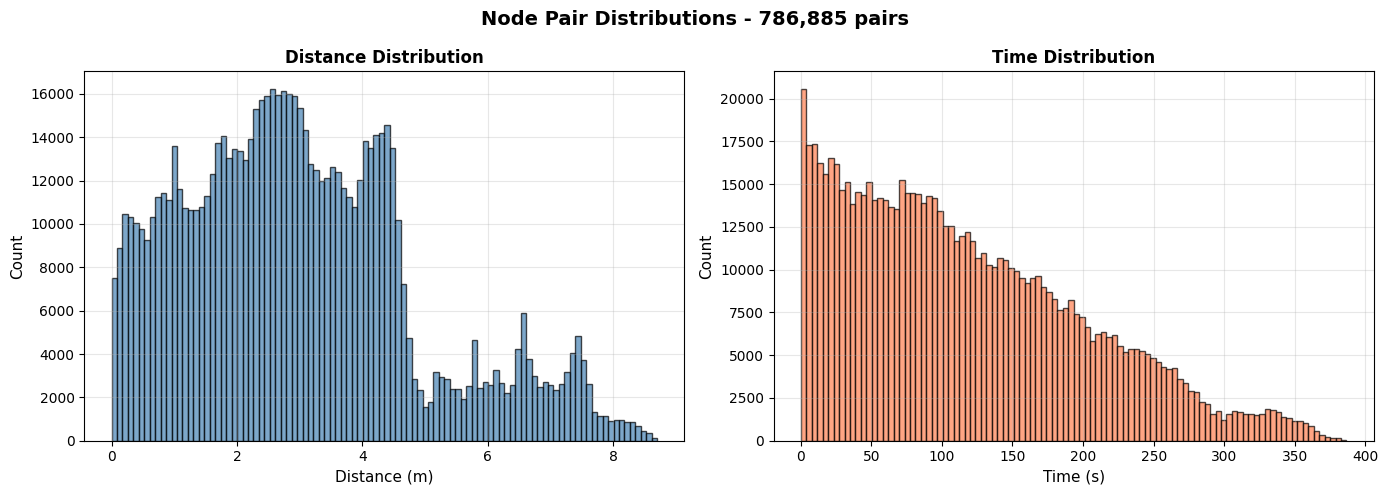

In [14]:
# Distribution plots
print("\n📊 DISTRIBUTIONS\n")

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distance histogram - remove empty bins by using data range
dist_data = df_all_pairs['distance_between_nodes_m'].values
counts1, bins1, _ = ax1.hist(dist_data, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Distance (m)', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Distance Distribution', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Time histogram - remove empty bins
time_data = df_all_pairs['time_diff_secs'].values
counts2, bins2, _ = ax2.hist(time_data, bins=100, color='coral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Time (s)', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('Time Distribution', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

fig.suptitle(f'Node Pair Distributions - {len(df_all_pairs):,} pairs', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
# Interactive filters
print("\n🎛️ INTERACTIVE FILTERS\n")

def filter_pairs(distance_mm, time_secs):
    distance_m = distance_mm / 1000.0

    filtered = df_all_pairs[
        (df_all_pairs['distance_between_nodes_m'] <= distance_m) &
        (df_all_pairs['time_diff_secs'] >= time_secs)
    ]

    print(f"\n📊 Filtered Results:")
    print(f"   Distance ≤ {distance_mm:.0f} mm ({distance_m:.3f} m)")
    print(f"   Time ≥ {time_secs:.1f} s")
    print(f"   Matching: {len(filtered):,} / {len(df_all_pairs):,} ({100*len(filtered)/len(df_all_pairs):.2f}%)")

    if len(filtered) > 0:
        print(f"\n📋 First 50:")
        display(filtered.head(50))
        print(f"\n📋 Last 50:")
        display(filtered.tail(50))
    else:
        print("\n⚠️  No matching pairs")

    global df_all_pairs_filtered
    df_all_pairs_filtered = filtered

interact(
    filter_pairs,
    distance_mm=FloatSlider(
        min=0, max=float(df_all_pairs['distance_between_nodes_m'].max() * 1000),
        step=1, value=30, description='Distance (mm):',
        style={'description_width': 'initial'}
    ),
    time_secs=FloatSlider(
        min=0, max=float(df_all_pairs['time_diff_secs'].max()),
        step=0.5, value=5, description='Time (s):',
        style={'description_width': 'initial'}
    )
);


🎛️ INTERACTIVE FILTERS



interactive(children=(FloatSlider(value=30.0, description='Distance (mm):', max=8700.594848514846, step=1.0, s…

---
# 5️⃣ DATA EXPORTING
---

In [16]:
# Export trajectory
print("📁 EXPORTING TRAJECTORY...\n")

trajectory_csv = f"{BASE_PATH}/trajectory.csv"
df_trajectory.to_csv(trajectory_csv, index=False)

print(f"✅ Exported: {len(df_trajectory)} nodes")
print(f"   File: {trajectory_csv}")

📁 EXPORTING TRAJECTORY...

✅ Exported: 1255 nodes
   File: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/trajectory.csv


In [17]:
# Export loop closures
print("\n📁 EXPORTING LOOP CLOSURES...\n")

loop_closures_csv = f"{BASE_PATH}/loop_closures.csv"
df_loop_closures.to_csv(loop_closures_csv, index=False)

print(f"✅ Exported: {len(df_loop_closures)} pairs")
print(f"   File: {loop_closures_csv}")


📁 EXPORTING LOOP CLOSURES...

✅ Exported: 406 pairs
   File: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/loop_closures.csv


In [18]:
# Export all pairs - FULL
print("\n📁 EXPORTING ALL NODE PAIRS (FULL)...\n")
print("⚠️  Large file (~786,885 rows)...\n")

all_pairs_full_csv = f"{BASE_PATH}/all_node_pairs_full.csv"
df_all_pairs.to_csv(all_pairs_full_csv, index=False)

print(f"✅ Exported: {len(df_all_pairs):,} pairs")
print(f"   File: {all_pairs_full_csv}")
print(f"   Size: {df_all_pairs.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


📁 EXPORTING ALL NODE PAIRS (FULL)...

⚠️  Large file (~786,885 rows)...

✅ Exported: 786,885 pairs
   File: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/all_node_pairs_full.csv
   Size: 24.01 MB


In [19]:
# Export all pairs - FILTERED
print("\n📁 EXPORTING ALL NODE PAIRS (FILTERED)...\n")

if 'df_all_pairs_filtered' in globals() and len(df_all_pairs_filtered) > 0:
    all_pairs_filtered_csv = f"{BASE_PATH}/all_node_pairs_filtered.csv"
    df_all_pairs_filtered.to_csv(all_pairs_filtered_csv, index=False)

    print(f"✅ Exported: {len(df_all_pairs_filtered):,} pairs")
    print(f"   File: {all_pairs_filtered_csv}")
else:
    print("⚠️  No filtered data. Use sliders in Section 4 first.")


📁 EXPORTING ALL NODE PAIRS (FILTERED)...

✅ Exported: 491 pairs
   File: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/all_node_pairs_filtered.csv


In [20]:
# Summary
print("\n" + "="*70)
print("✨ EXPORT COMPLETE")
print("="*70)
print(f"\n📂 Saved to: {BASE_PATH}\n")
print("Files:")
print("   1. trajectory.csv")
print("   2. loop_closures.csv")
print("   3. all_node_pairs_full.csv")
print("   4. all_node_pairs_filtered.csv (if filtered)")
print("\n" + "="*70)


✨ EXPORT COMPLETE

📂 Saved to: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137

Files:
   1. trajectory.csv
   2. loop_closures.csv
   3. all_node_pairs_full.csv
   4. all_node_pairs_filtered.csv (if filtered)

